In [1]:
import os, sys
import numpy as np
import uproot
import awkward as ak
import pandas as pd
from time import time

import pickle
import json

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")


In [2]:
# path_to_repo = '/'.join(os.getcwd().split('/')[:-1])
path_to_repo = '/home/rusack/vadna042/HGCALDRNElectron'
sys.path.append(path_to_repo)

from utils.pltutils import plt
plt.style.use(path_to_repo+'/utils/simple.mplstyle')

from utils.fitting_tools import GausPDF, Pol1PDF, fit_gaussian_res

In [3]:
#prediction_file = '<path_to_prediction_file>'
prediction_file = '/home/rusack/vadna042/DNNoutput/flat_predictions.pickle'
target_file = '/home/rusack/shared/pickles/hgcal_electron/flat_combined/all_target.pickle'

In [4]:
with open(prediction_file, 'rb') as file_:
    predictions = pickle.load(file_)
with open(target_file, 'rb') as file_:
    targets = pickle.load(file_)

In [5]:
rechit_energy_file = '/home/rusack/shared/pickles/hgcal_electron/flat_combined/rechit_energy.pickle'
with open(rechit_energy_file, 'rb') as file_:
    energies = pickle.load(file_)

In [6]:
fit_parameters_ml_train = {}
fit_parameters_sum = {}

<Figure size 432x288 with 0 Axes>

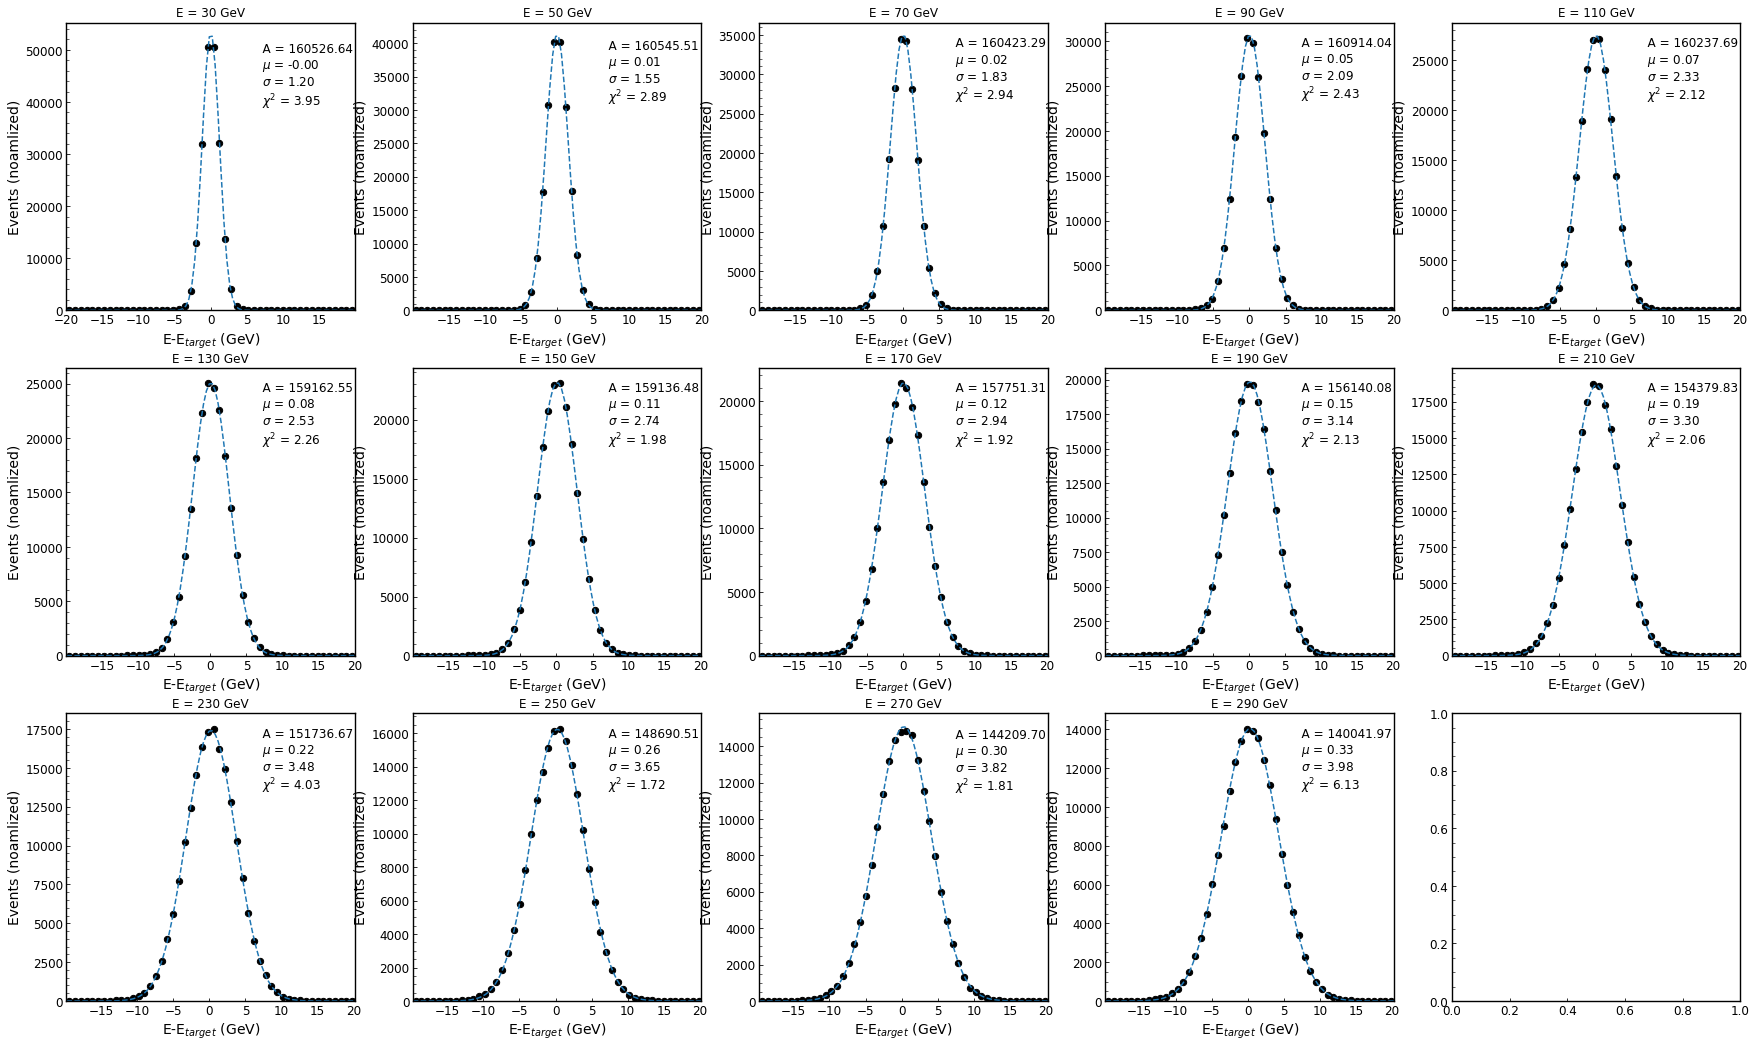

In [7]:
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(predictions)[mask]
    fit_parameters_ml_train[e] = fit_gaussian_res(P-T, axarray[irow, jcol], e)
plt.show()

In [ ]:
plt.clf()
fig, axarray = plt.subplots(3, 5)
fig.set_figheight(18)
fig.set_figwidth(30)

sigma_e = []
mean_e = []
target_e = []

for i in range(14):
    irow = int(i/5)
    jcol = int(i%5)
    e = (2*i+3)*10
    e_min = (i+1)*20
    e_max = (i+2)*20
    mask = np.logical_and(targets>e_min, targets<e_max)
    T = np.array(targets)[mask]
    P = np.array(ak.sum(energies, axis=1)[mask]*0.01)
    fit_parameters_sum[e] = fit_gaussian_res(P-T, axarray[irow, jcol], e)
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

mean_e = 1/np.sqrt(np.array([ e for e in fit_parameters_ml_train]))
res_e = np.array([ fit_parameters_ml_train[e][2]/e for e in fit_parameters_ml_train])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='black', label='ml method',
            facecolor='w')
res_results_ml = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

res_e = np.array([fit_parameters_sum[e][2]/e for e in fit_parameters_sum])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='red', label='Sum',
            facecolor='w')
res_results_sum = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))


xarray = np.linspace(0.0, 0.55, 64)
yarray_data_sum =  res_results_sum[0][0]*xarray+res_results_sum[0][1]
yarray_data_ml = res_results_ml[0][0]*xarray+res_results_ml[0][1]

plt.plot(xarray, yarray_data_sum, c='red', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(res_results_sum[0][0]*100, res_results_sum[0][1]*100))
plt.plot(xarray, yarray_data_ml, c='black', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(res_results_ml[0][0]*100, res_results_ml[0][1]*100))

cms = plt.text(x=0.0, y=0.1, s="CMS $\it{Preliminary}$",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.06, y=0.035, s='')

plt.ylim(0.0, 0.05)
plt.xlim(0.0, 0.30)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import uproot
import awkward as ak
import pickle
import os
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd



class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.input_size = 28
        self.hidden_size1 = 40
        self.hidden_size2 = 30
        self.output_size = 1
        
        self.network = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, self.output_size),
            nn.Softplus())

    def forward(self, data):
        return self.network(data)

    
def train(model, x, y, optimizer, criterion):
    model.zero_grad()
    output = model(x)
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()

    return loss, output
    
#loss function to avoid overflow
def MARE(x,y):
    return (sum(abs(x-y)/y))/len(y)
    
    
net = NN()
criterion = MARE
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001)

In [ ]:
new_files_list = [30,50,80,100,150,200,250,300]

# ====load NN state
net = NN()
net.load_state_dict(torch.load('/home/rusack/vadna042/DNNstates/largeTest/epochfinal'))
net.eval()

layers = []
energy = []        
for x in new_files_list:
    with open(f'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/{x}/rechit_z.pickle', 'rb') as a1:
        layers.append(pickle.load(a1))
    with open(f'/home/rusack/shared/pickles/hgcal_electron/data_h3_selection/{x}/rechit_energy.pickle', 'rb') as a2:
        energy.append(pickle.load(a2))
    
sum_e_layers = []    
for i in range(len(layers)):    
    layer_position = np.unique(ak.flatten(layers[i]))[0:28]
    temp = [ ak.sum(energy[i][layers[i]==lz], axis=1) for lz in layer_position ]
    sum_e_layers.append(torch.Tensor(temp))

In [ ]:
#Run it through the network.
output_run = [torch.detach(net(sum_e_layers[i].T)).numpy() for i in range(len(sum_e_layers))]

In [ ]:
#CURVE FITTING SEGMENT

def Gauss(x, A, B, C):
    return A*np.exp(-1*(x-B)**2/(2*C**2))

def line(x, A, B):
    return A*x + B

#Fit a gaussian to each data set
parameters=[]
for i, y in enumerate(output_run):
    bins = 200
    ydata, xdata = np.histogram(y, range = [np.mean(y)-(i+1)*7, np.mean(y)+(i+1)*7],bins = bins)
    xdata = xdata[:bins] 
    guess = [max(ydata),
             np.average(xdata,weights=ydata),
             np.sqrt(np.std(ydata))*0.1] 

    param, paramconv = curve_fit(Gauss, xdata, ydata, p0=guess, maxfev=10000, bounds = ([0,10,0],[10000,350,400]))
    param[2] = abs(param[2])
    # print(param)
    parameters.append(param)
    
    fit_y = Gauss(xdata, param[0], param[1], param[2])
#     plt.figure()
#     plt.plot(xdata, ydata, 'o', label='data') #Is the shift constant or dependent on energy?
#     plt.plot(xdata, fit_y, '-', label='fit')
#     plt.legend()
#     plt.xlabel('Energy GeV')
#     plt.ylabel('Event count')
#     plt.title(f"{new_files_list[i]} GeV MC DNN prediction")
#     plt.show() 
#     output_dataframe = pd.DataFrame([[xdata[i],ydata[i]] for i in range(len(ydata))], columns = ['energy_GeV','event_count'])
#     output_dataframe.to_csv(f'mc_h3_processed\{new_files_list[i]}.csv') #Change FILEPATH
    
parameters_sum=[]
fori,y in enumerate
    
# Fit a line to the energy resolution data set

#=====Create cumulative dataset
energy_x = np.asarray([1/np.sqrt(new_files_list[i]) for i in range(len(parameters))])
energy_y = np.asarray([parameters[i][2]/new_files_list[i] for i in range(len(parameters))])
output_data = np.asarray([[energy_x[i], energy_y[i]] for i in range(len(parameters))])
    
#=====Create the guess and fit
slope = (energy_y[len(parameters)-1] - energy_y[0]) / (energy_x[len(parameters)-1] - energy_x[0])
intercept = energy_y[0] - slope*energy_x[0]
energy_guess = [slope,intercept]
energy_param, energy_cov = curve_fit(line, energy_x, energy_y, p0 = energy_guess)
linfit = line(energy_x, energy_param[0], energy_param[1])

#=====plot the data and fit, check to see if params are in correct units...
plt.figure()
plt.plot(energy_x,energy_y, 'o', label='data')
plt.plot(energy_x,linfit, '-', label='fit')
plt.legend()
plt.xlabel('1 / $\sqrt{Energy}')
plt.ylabel('Sigma_E / <E>')
plt.title('data Energy Resolution plot')
plt.text(0.11,0.02,f'Slope: {energy_param[0]}\nIntercept: {energy_param[1]}')
# plt.savefig('mc_h3_processed\linplot.png', dpi=350, transparent=False)
plt.show()

#=======Create the csv result file
# output_dataframe = pd.DataFrame(output_data, columns = ['Energy^-1/2','SigmaE/<E>'])
# output_dataframe.to_csv('mc_h3_processed\linfit.csv') #Change FILEPATH

<Figure size 432x288 with 0 Axes>

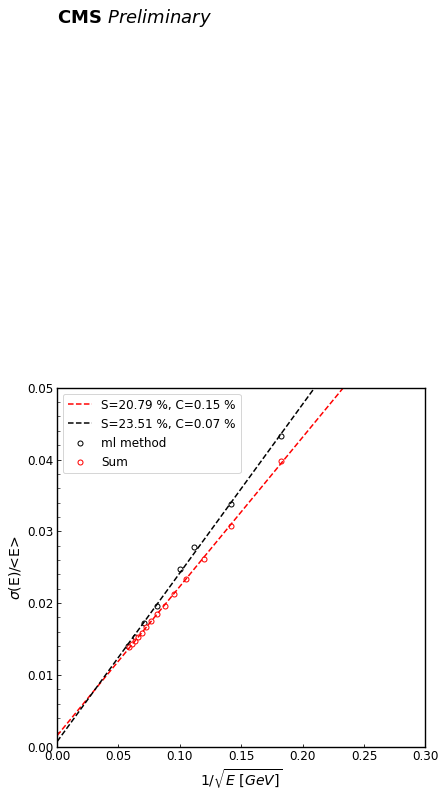

In [16]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

mean_e = 1/np.sqrt(np.array([ e for e in fit_parameters_ml_train]))
res_e = np.array([ fit_parameters_ml_train[e][2]/e for e in fit_parameters_ml_train])
plt.scatter(energy_x, energy_y,
            marker='.', s=100, edgecolor='black', label='ml method',
            facecolor='w')
res_results_ml = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

res_e = np.array([fit_parameters_sum[e][2]/e for e in fit_parameters_sum])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='red', label='Sum',
            facecolor='w')
res_results_sum = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))


xarray = np.linspace(0.0, 0.55, 64)
yarray_data_sum =  res_results_sum[0][0]*xarray+res_results_sum[0][1]
yarray_data_ml = res_results_ml[0][0]*xarray+res_results_ml[0][1]

linfit2 = line(xarray, energy_param[0], energy_param[1])

plt.plot(xarray, yarray_data_sum, c='red', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(res_results_sum[0][0]*100, res_results_sum[0][1]*100))
plt.plot(xarray, linfit2, c='black', linestyle='--',
         label='S={:0.2f} %, C={:0.2f} %'.format(energy_param[0]*100, energy_param[1]*100))

cms = plt.text(x=0.0, y=0.1, s="CMS $\it{Preliminary}$",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.06, y=0.035, s='')

plt.ylim(0.0, 0.05)
plt.xlim(0.0, 0.30)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()